Transformei os arquivos .txt em um arquivo .csv para facilitar a leitura 



In [2]:
import pandas as pd
import os

# Função para ler todos os arquivos .txt de um diretório
def ler_arquivos_txt(diretorio):
    dados = []
    for filename in sorted(os.listdir(diretorio), key=lambda x: int(x.split('.')[0])):
        if filename.endswith('.txt'):
            with open(os.path.join(diretorio, filename), 'r', encoding='utf-8') as file:
                dados.append(file.read().strip())
    return dados

# Diretórios dos arquivos true e fake
diretorio_true = 'C:/Users/patri/Desktop/faculdade/4 Bimestre 2024/PLN/trabalho prático/Fake.br-Corpus/size_normalized_texts/true'
diretorio_fake = 'C:/Users/patri/Desktop/faculdade/4 Bimestre 2024/PLN/trabalho prático/Fake.br-Corpus/size_normalized_texts/fake'

# Leitura dos arquivos .txt
true_data = ler_arquivos_txt(diretorio_true)
fake_data = ler_arquivos_txt(diretorio_fake)

# Criação do DataFrame
data = {
    'true': true_data,
    'fake': fake_data
}

df = pd.DataFrame(data) #criação do dataframe com os dados data

# Salvando o DataFrame em um arquivo .csv
df.to_csv('C:/Users/patri/Desktop/faculdade/4 Bimestre 2024/PLN/trabalho prático/Fake.br-Corpus/saida.csv', index=False, encoding='utf-8')

print("Arquivo CSV salvo com sucesso!")


Arquivo CSV salvo com sucesso!


Verificando se o dataframe foi criado corretamente


In [17]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import re, os 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from tqdm import tqdm 

In [56]:
#épocas de treinamento
epochs = 5

# Dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50

# Número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 32

# Quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 5000

# Dimensão de saída da camada Embedding
embed_dim = 128

# Limitação do tamanho máximo de todas as sentenças
max_sequence_length = 300

In [18]:
import pandas as pd
df_usado = pd.read_csv("C:/Users/patri/Desktop/faculdade/4 Bimestre 2024/PLN/trabalho prático/Fake.br-Corpus/saida.csv")

In [19]:
df_usado.head(500)


,true,fake
0,O Podemos decidiu expulsar o deputado federal...,Kátia Abreu diz que vai colocar sua expulsão e...
1,Em evento realizado nesta terça-feira para div...,Blog esquerdista dá a entender que reclamar de...
2,﻿Após o prefeito de Manaus Arthur Virgílio (PS...,"Alckmin diz que por ele PSDB “desembarca”, mas..."
3,﻿Doria vai receber Zé Celso após reunião com r...,Cara de pau não tem limites: Zé Celso aciona M...
4,"Gustavo Pedreira Ferraz, que admitiu buscar ma...",Temer resolve o problema de Luislinda: “liberd...
...,...,...
495,Temor de conflito nuclear impulsiona venda de ...,"Americanos investem até R$ 5 milhões em ""bunke..."
496,Chefe de Inteligência da PM viajou para a Euro...,Bombeiro furta caminhão de quartel para jogar ...
497,A realidade é pior que você imagina: a jornali...,"Ex-diretora do Banco Mundial: ""Uma outra raça ..."
498,"Quarta-feira, 17 de maio de 2017. Boa noite! A...",Astróloga mais famosa do mundo diz que Lula se...


corrigindo acentuação


In [35]:
# Função para corrigir a acentuação das palavras
import unicodedata

def corrigir_acentuacao(texto):
    return ''.join(
        (c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    )

# Aplicando a correção de acentuação nos dados
df_usado['true'] = df_usado['true'].apply(corrigir_acentuacao)
df_usado['fake'] = df_usado['fake'].apply(corrigir_acentuacao)

print("Acentuação corrigida com sucesso!")


Acentuação corrigida com sucesso!


limpeza dos dados

aplicando limpeza no df_usado 

In [36]:
# Função para remover caracteres especiais, símbolos desnecessários e pontuações
def limpar_dados(texto):
    texto = re.sub(r'[^a-zA-Z0-9\s]', '', texto)  # Remove caracteres especiais
    texto = texto.lower()  # Converte para minúsculas
    texto = ' '.join(texto.split())  # Remove espaços extras
    return texto

# Aplicando a limpeza de dados no DataFrame df_usado
df_usado['true'] = df_usado['true'].apply(limpar_dados)
df_usado['fake'] = df_usado['fake'].apply(limpar_dados)

print("Dados limpos com sucesso!")




Dados limpos com sucesso!


In [37]:
# Transformando todos os textos em letra minúscula
df_usado['true'] = df_usado['true'].str.lower()
df_usado['fake'] = df_usado['fake'].str.lower()

print("Textos transformados para letra minúscula com sucesso!")


Textos transformados para letra minúscula com sucesso!


balanceando os dados para que o modelo não seja afetado por uma grande diferença de palavras


In [29]:
# Garantindo que o número de rótulos REAL e FAKE seja o mesmo

# Contando o número de entradas para cada rótulo
num_real = len(df_usado['true'])
num_fake = len(df_usado['fake'])

# Encontrando o menor número entre os dois rótulos
min_count = min(num_real, num_fake)

# Amostrando aleatoriamente o mesmo número de entradas para ambos os rótulos
df_real_balanced = df_usado['true'].sample(n=min_count, random_state=42)
df_fake_balanced = df_usado['fake'].sample(n=min_count, random_state=42)

# Combinando os dados balanceados em um novo DataFrame
df_balanced = pd.DataFrame({'true': df_real_balanced, 'fake': df_fake_balanced})

print("Dados balanceados com sucesso!")


Dados balanceados com sucesso!


In [39]:
import re

def remover_caracteres_especiais(texto):
    # Remove caracteres especiais, símbolos desnecessários e pontuações
    return re.sub(r'[^a-zA-Z0-9\s]', '', texto)

# Aplicando a remoção de caracteres especiais nos dados
df_balanced['true'] = df_balanced['true'].apply(remover_caracteres_especiais)
df_balanced['fake'] = df_balanced['fake'].apply(remover_caracteres_especiais)

print("Caracteres especiais removidos com sucesso!")


Caracteres especiais removidos com sucesso!


comando str.lower() para transformar todos os textos em letra minúscula


In [40]:
df_usado.head()

,true,fake
0,o podemos decidiu expulsar o deputado federal ...,katia abreu diz que vai colocar sua expulsao e...
1,em evento realizado nesta tercafeira para divu...,blog esquerdista da a entender que reclamar de...
2,apos o prefeito de manaus arthur virgilio psdb...,alckmin diz que por ele psdb desembarca mas na...
3,doria vai receber ze celso apos reuniao com re...,cara de pau nao tem limites ze celso aciona mp...
4,gustavo pedreira ferraz que admitiu buscar mal...,temer resolve o problema de luislinda liberdad...


In [42]:
df_usado.dropna() #removendo linhas com valores nulos


,true,fake
1340,veja avancos da ciencia que ganharam destaque ...,ataque biologico coreia do norte descobre pand...
1601,dem lanca precandidatura de rodrigo maia a pre...,globo dispensa diretor do domingao do faustao ...
3549,eu me lembro eu me lembro era pequeno deus cas...,filho de lula nao soube explicar como ganhou r...
3575,gosto quando dizem que sou caso de marketing 2...,vitor belfort vence luta no mmasp e manda reca...
211,a gente quer odiar a religiao ela merece diz c...,temer pretende cobrar imposto de igrejas ele a...
...,...,...
1130,o debate no tribunal superior eleitoral tse qu...,video mostra ministro sendo hostilizado na sai...
1294,cinco perguntas para entender a crise com a co...,tiro no pe trump pode atacar a coreia e sofrer...
860,o que se sabe sobre o programa nuclear da core...,coreia do norte lanca missil em direcao ao jap...
3507,maioria oposicionista no peru pede que preside...,deputado cunha e literalmente humilhado no ple...


verificando número de linhas


In [60]:
# Verificando o número de linhas de 'true' e 'fake'
num_linhas_true = len(df_balanced['true'])
num_linhas_fake = len(df_balanced['fake'])

print(f"Número de linhas em 'true': {num_linhas_true}")
print(f"Número de linhas em 'fake': {num_linhas_fake}")


Número de linhas em 'true': 3600
Número de linhas em 'fake': 3600


tokenizando o texto com nltk e treinando o modelo 

In [71]:

# Separando os dados em 75% para treinamento e 25% para teste
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from tensorflow.keras.models import Model
import numpy as np



In [72]:
# Tokenizando o texto com nltk
df_usado['true'] = df_usado['true'].apply(word_tokenize)
df_usado['fake'] = df_usado['fake'].apply(word_tokenize)

# Transformando as listas de tokens em strings novamente
df_usado['true'] = df_usado['true'].apply(lambda x: ' '.join(x))
df_usado['fake'] = df_usado['fake'].apply(lambda x: ' '.join(x))


modelo de treinamento 



In [73]:

def model():  # Certifique-se de que não há parâmetros aqui
    input_shape = (max_sequence_length,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')    
    embedding = Embedding(max_fatures, embed_dim, name="embedding")(model_input) 
    gru = GRU(embed_dim,name="gru")(embedding)
    model_output = Dense(2, activation='softmax', name="softmax")(gru)
    model = Model(inputs=model_input, outputs=model_output)
    return model

In [ ]:
model = model()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [78]:
df_usado.head()

,true,fake,label,label_true,label_fake
0,o podemos decidiu expulsar o deputado federal ...,katia abreu diz que vai colocar sua expulsao e...,1,1,0
1,em evento realizado nesta tercafeira para divu...,blog esquerdista da a entender que reclamar de...,1,1,0
2,apos o prefeito de manaus arthur virgilio psdb...,alckmin diz que por ele psdb desembarca mas na...,1,1,0
3,doria vai receber ze celso apos reuniao com re...,cara de pau nao tem limites ze celso aciona mp...,1,1,0
4,gustavo pedreira ferraz que admitiu buscar mal...,temer resolve o problema de luislinda liberdad...,1,1,0


In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Função para gerar bigramas e calcular TF-IDF
def gerar_tfidf_bigrams(texts):
    vectorizer = TfidfVectorizer(ngram_range=(2, 2))  # Configurando para bigramas
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix, vectorizer

# Gerando TF-IDF para bigramas dos textos true
tfidf_true, vectorizer_true = gerar_tfidf_bigrams(df_combined[df_combined['label'] == 1]['text'].values)

# Gerando TF-IDF para bigramas dos textos fake
tfidf_fake, vectorizer_fake = gerar_tfidf_bigrams(df_combined[df_combined['label'] == 0]['text'].values)

# Exibindo algumas estatísticas dos bigramas
print("Estatísticas de TF-IDF para bigramas em textos true:")
print(tfidf_true.shape)

print("\nEstatísticas de TF-IDF para bigramas em textos fake:")
print(tfidf_fake.shape)


Estatísticas de TF-IDF para bigramas em textos true:
(3600, 266748)

Estatísticas de TF-IDF para bigramas em textos fake:
(3600, 278538)


treinamento do modelo 

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Bidirectional, Flatten

# Parâmetros do modelo
epochs = 5  # Aumentando o número de épocas para melhorar a acurácia
word_embedding_dim = 50
batch_size = 32
max_features = 10000  # Corrigindo o nome da variável para 'max_features'
embed_dim = 128
max_sequence_length = 300

# Adicionando rótulos
df_usado['label_true'] = 1
df_usado['label_fake'] = 0

# Combinando os dados true e fake
df_combined_true = df_usado[['true', 'label_true']].rename(columns={'true': 'text', 'label_true': 'label'})
df_combined_fake = df_usado[['fake', 'label_fake']].rename(columns={'fake': 'text', 'label_fake': 'label'})
df_combined = pd.concat([df_combined_true, df_combined_fake], axis=0)

# Tokenizando o texto
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_combined['text'].values)
X = tokenizer.texts_to_sequences(df_combined['text'].values)
X = pad_sequences(X, maxlen=max_sequence_length)

# Convertendo os rótulos para numpy array
labels = df_combined['label'].values

# Separando os dados em treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

# Definindo o modelo
def criar_modelo():
    input_shape = (max_sequence_length,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')
    embedding = Embedding(max_features, embed_dim, name="embedding")(model_input)  # Corrigindo o nome da variável para 'max_features'
    gru = Bidirectional(GRU(embed_dim, return_sequences=True, name="gru"))(embedding)
    flatten = Flatten()(gru)  # Adicionando a camada Flatten para ajustar a dimensão
    model_output = Dense(1, activation='sigmoid', name="sigmoid")(flatten)  # Adicionando a camada de saída ao modelo
    model = Model(inputs=model_input, outputs=model_output)
    return model

# Criando e compilando o modelo
model = criar_modelo()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
hist = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_test, Y_test),
        epochs=epochs,
        batch_size=batch_size, 
        shuffle=True,
        verbose=1)

Epoch 1/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.6451 - loss: 0.5874 - val_accuracy: 0.8911 - val_loss: 0.2733
Epoch 2/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.9595 - loss: 0.1265 - val_accuracy: 0.8778 - val_loss: 0.3102
Epoch 3/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.9879 - loss: 0.0452 - val_accuracy: 0.8650 - val_loss: 0.4436
Epoch 4/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.9986 - loss: 0.0100 - val_accuracy: 0.8722 - val_loss: 0.4785
Epoch 5/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.9977 - loss: 0.0083 - val_accuracy: 0.8622 - val_loss: 0.5444


In [98]:
!pip install wordcloud


   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/300.2 kB 330.3 kB/s eta 0:00:01
   ------------ --------------------------- 92.2/300.2 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.3 MB/s eta 0:00:00


In [102]:
# Definindo uma lista de stopwords (preposições e artigos) para remover dos textos
stopwords = set(['de', 'da', 'do', 'das', 'dos', 'um', 'uma', 'uns', 'umas', 'a', 'o', 'as', 'os','que','para','em','na','no'])

# Função para remover stopwords de um texto
def remover_stopwords(texto):
    palavras = texto.split()
    palavras_filtradas = [palavra for palavra in palavras if palavra.lower() not in stopwords]
    return ' '.join(palavras_filtradas)

# Aplicando a função de remoção de stopwords aos textos
df_combined['text'] = df_combined['text'].apply(remover_stopwords)


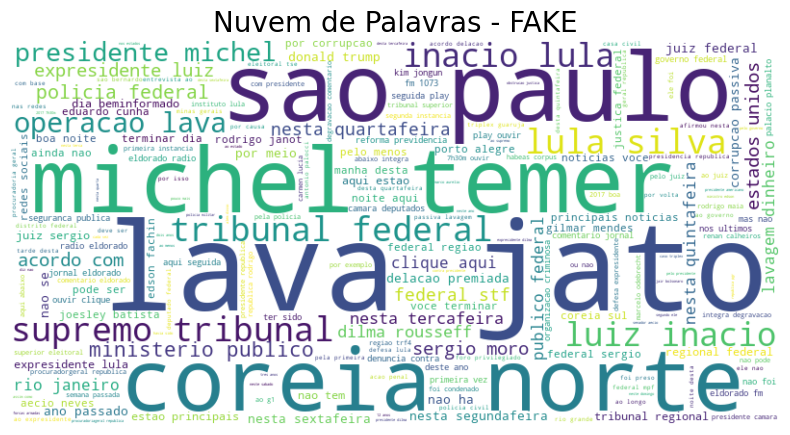

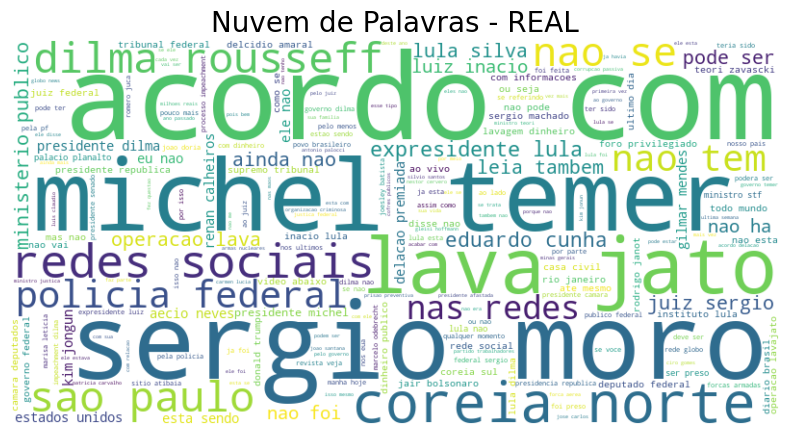

In [104]:
# Gerando nuvens de palavras para as classes FAKE e REAL
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Função para gerar e exibir a nuvem de palavras para bi-gramas
def gerar_nuvem_palavras(texto, titulo):
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform([texto])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titulo, fontsize=20)
    plt.axis('off')
    plt.show()

# Concatenando todos os textos das classes FAKE e REAL
texto_fake = ' '.join(df_combined[df_combined['label'] == 1]['text'])
texto_real = ' '.join(df_combined[df_combined['label'] == 0]['text'])

# Gerando e exibindo as nuvens de palavras para bi-gramas
gerar_nuvem_palavras(texto_fake, 'Nuvem de Palavras - FAKE')
gerar_nuvem_palavras(texto_real, 'Nuvem de Palavras - REAL')


questão 1) crie uma nuvem de palavras com os termos ou palavras que 
foram considerados para a classificação dos textos POSITIVOS.

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


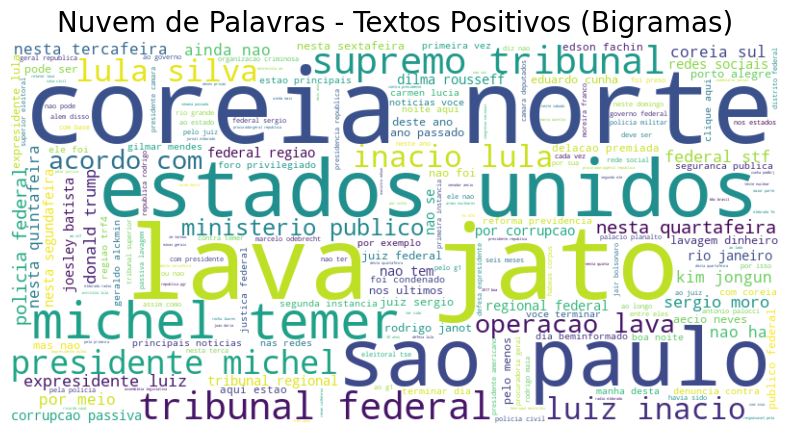

In [108]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Fazendo previsões com o modelo
predicoes = model.predict(X_test)
predicoes = (predicoes > 0.5).astype(int).flatten()

# Filtrando os textos classificados como positivos pelo modelo
textos_positivos = df_combined.iloc[np.where(predicoes == 1)[0]]['text']

# Concatenando todos os textos positivos em uma única string
texto_concatenado = ' '.join(textos_positivos)

# Gerando a nuvem de palavras para bi-gramas
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform([texto_concatenado])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq))

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Textos Positivos (Bigramas)', fontsize=20)
plt.axis('off')
plt.show()

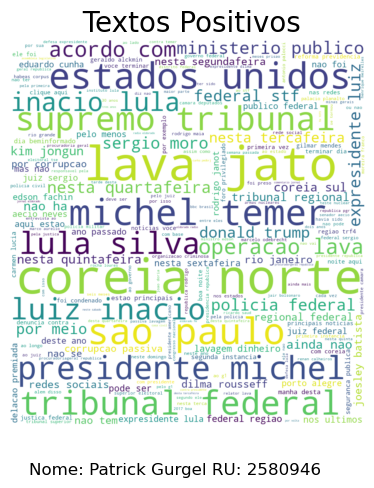

In [120]:
from PIL import Image
import numpy as np



# Gerar a nuvem de palavras com a máscara do dedo positivo
wordcloud = WordCloud(width=800, height=400, background_color='white', mask=dedo_positivo, contour_color='lightgreen', contour_width=3).generate_from_frequencies(dict(words_freq))

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(' Textos Positivos', fontsize=20)
plt.figtext(0.5, 0.01, 'Nome: Patrick Gurgel RU: 2580946', ha='center', fontsize=12)
plt.axis('off')
plt.show()

# >> (nome: Patrick Gurgel RU: 2580946)


questão 2) Apresente aqui o código referente ao modelo 
gerado e a nuvem de palavras que foram usadas para identificar 
textos FALSOS. 

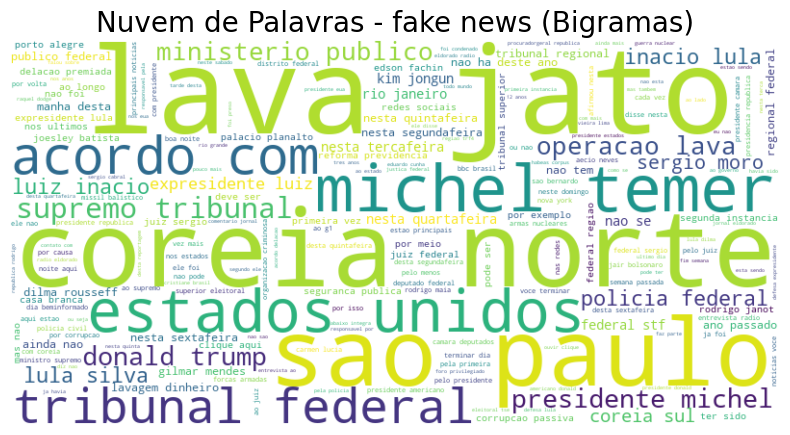

In [122]:
# Filtrando os textos classificados como negativos pelo modelo
textos_negativos = df_combined.iloc[np.where(predicoes == 0)[0]]['text']

# Concatenando todos os textos negativos em uma única string
texto_concatenado_negativo = ' '.join(textos_negativos)

# Gerando a nuvem de palavras para bi-gramas
vectorizer_negativo = CountVectorizer(ngram_range=(2, 2))
bag_of_words_negativo = vectorizer_negativo.fit_transform([texto_concatenado_negativo])
sum_words_negativo = bag_of_words_negativo.sum(axis=0)
words_freq_negativo = [(word, sum_words_negativo[0, idx]) for word, idx in vectorizer_negativo.vocabulary_.items()]
words_freq_negativo = sorted(words_freq_negativo, key=lambda x: x[1], reverse=True)
wordcloud_negativo = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq_negativo))

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negativo, interpolation='bilinear')
plt.title('Nuvem de Palavras - fake news (Bigramas)', fontsize=20)
plt.axis('off')
plt.show()


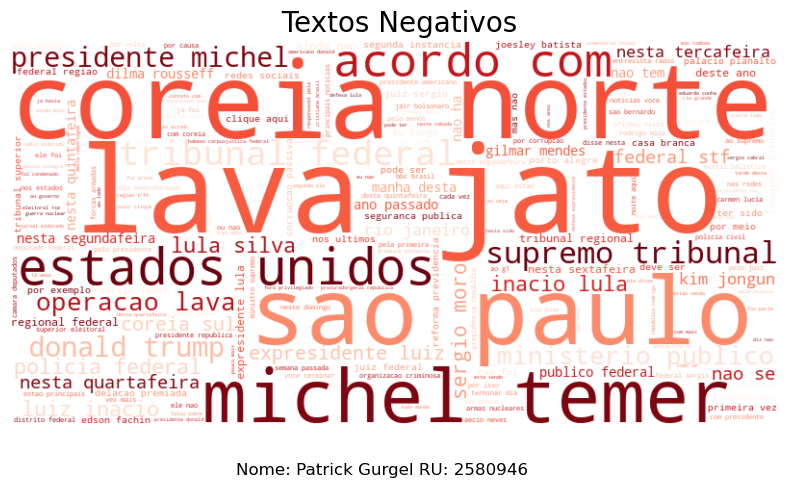

In [124]:
# Gerar a nuvem de palavras sem a máscara do dedo negativo
wordcloud_negativo = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(dict(words_freq_negativo))

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negativo, interpolation='bilinear')
plt.title(' Textos Negativos', fontsize=20)
plt.figtext(0.5, 0.01, 'Nome: Patrick Gurgel RU: 2580946', ha='center', fontsize=12)
plt.axis('off')
plt.show()
